# Basic Statistics on UKB dataset

Set up global variables and import modules

In [29]:
%matplotlib inline
import os
import sys
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 

ukb_root = '/project_freenas/3022017.02/UKB'
sys.path.append(os.path.join(ukb_root,'scripts'))
from ukb_utils import get_variables_UKB, lookup_UKB

ukb_idp_dir = os.path.join(ukb_root,'phenotypes','current')

### Read dataframe

In [30]:
basic_demo = pd.read_csv(os.path.join(ukb_idp_dir,'01_basic_demographics.csv'),nrows=1)
brain_IDPs = pd.read_csv(os.path.join(ukb_idp_dir,'31_brain_IDPs.csv'),nrows=1)
misc = pd.read_csv(os.path.join(ukb_idp_dir,'99_miscellaneous.csv'),nrows=1)

Lookup field IDs with Lookup_UKB function <br>
This will to help figure out what fields are present in the dataframe

In [31]:
def list_field_names(data_frame):
    fields_ID = data_frame.columns
    field_list = pd.DataFrame(columns=['Field', 'FieldID'])
    for idf in fields_ID[1:]:
        fld = lookup_UKB(field_ids=[idf]) 
        field_list = field_list.append(fld)
    return field_list 

Save resulted dataframes for later use. This may take a while.

In [32]:
#brain_IDPs_fields = list_field_names(brain_IDPs)
#brain_IDPs_fields.to_csv('/home/preclineu/ramcir/Desktop/Diffusion/diffusion_nm/brain_IDPs_fields.csv')
#basic_demo_fields = list_field_names(basic_demo)
#basic_demo_fields.to_csv('/home/preclineu/ramcir/Desktop/Diffusion/diffusion_nm/basic_demo_fields.csv')
#misc_fields = list_field_names(misc)

Turns out some dataframes contain too many fields to allow for visual inspection. As an alternative, specific metrics (field names) can be looked up on the UK Biobank website and their respective field codes can be used to extract data from the containing dataframe.

### Identifying and extracting subjects who present diffusion data

Join the dataframes which contain dMRI metrics with the demographics dataframes and exclude NaNs

In [33]:
lookup_UKB(field_ids=[25922])

,Field,FieldID
2893,Standard deviation of apparent translation in ...,25922


In [34]:
# first check inside the brain IDP dataframe for the metric we are interssted in
fieldID_check = brain_IDPs.filter(regex='25922')
fieldID_check

""
0


#### Using my way (more complicated)

In [130]:
# read the demographic metric we are intersted in, remove the NANs
basic_demo = pd.read_csv(os.path.join(ukb_idp_dir,'01_basic_demographics.csv'), usecols = ['eid','34-0.0'], low_memory = True)
basic_demo.dropna(inplace=True)

In [131]:
# read the dMRI metric we are intersted in, remove the NANs
brain_IDPs = pd.read_csv(os.path.join(ukb_idp_dir,'31_brain_IDPs.csv'), usecols = ['eid','25737-2.0'], low_memory = True)
brain_IDPs.dropna(inplace=True)

In [132]:
# filer the demo dataframe by the participants in the diffusion dataframe
filt_basic_demo = basic_demo.loc[basic_demo['eid'].isin(brain_IDPs['eid'])]

#### Using load_ukb_metrics (more straightforward)

In [186]:
# we get the sex from basic demographics
field_codes = ['eid','31-0.0']
field_names = ['eid', 'sex']
df_sex, subs = get_variables_UKB(os.path.join(ukb_idp_dir,'01_basic_demographics.csv'), field_codes, field_names)

# we load the age from the miscellaneous (because age at enrollment != age at scanning)
field_codes = ['eid', '21003-2.0', '54-2.0']
field_names = ['eid', 'age', 'site']
df_age, subs = get_variables_UKB(os.path.join(ukb_idp_dir,'99_miscellaneous.csv'), field_codes, field_names)

# load dMRI data
field_codes = ['eid', '25746-2.0', '25737-2.0']
field_names = ['eid', 'dmri_slices_corrected', 'discrepancy_dmri_t1']
df_dmri, subs = get_variables_UKB(os.path.join(ukb_idp_dir,'31_brain_IDPs.csv'), field_codes, field_names)


In [187]:
# join the dataframes
dmri_demo = df_sex.join(df_age).join(df_dmri)

dmri_demo.dropna(inplace=True)

In [188]:
print(dmri_demo.shape)
#display(df)

(40527, 5)


### Summary statistics

### Threshold the distribution of the dMRI parameters

In [173]:
#def remove_outlier(dataFrame, col_name, threshold):
#    return dataFrame[dataFrame[col_name] < threshold]
#th1_dmri_demo = remove_outlier(dmri_demo,'discrepancy_dmri_t1', 0.7)

In [195]:
th1_dmri_demo = dmri_demo.copy(deep=True)
th1_dmri_demo['discrepancy_dmri_t1'] = dmri_demo['discrepancy_dmri_t1'].mask(dmri_demo['discrepancy_dmri_t1']>0.7)
th1_dmri_demo.dropna(inplace=True)

In [197]:
th2_dmri_demo = th1_dmri_demo.copy(deep=True)
th2_dmri_demo['dmri_slices_corrected'] = th1_dmri_demo['dmri_slices_corrected'].mask(th1_dmri_demo['dmri_slices_corrected']>100)
th2_dmri_demo.dropna(inplace=True)

In [198]:
display(dmri_demo.shape)
display(th1_dmri_demo.shape)
display(th2_dmri_demo.shape)

(40527, 5)

(38140, 5)

(35873, 5)

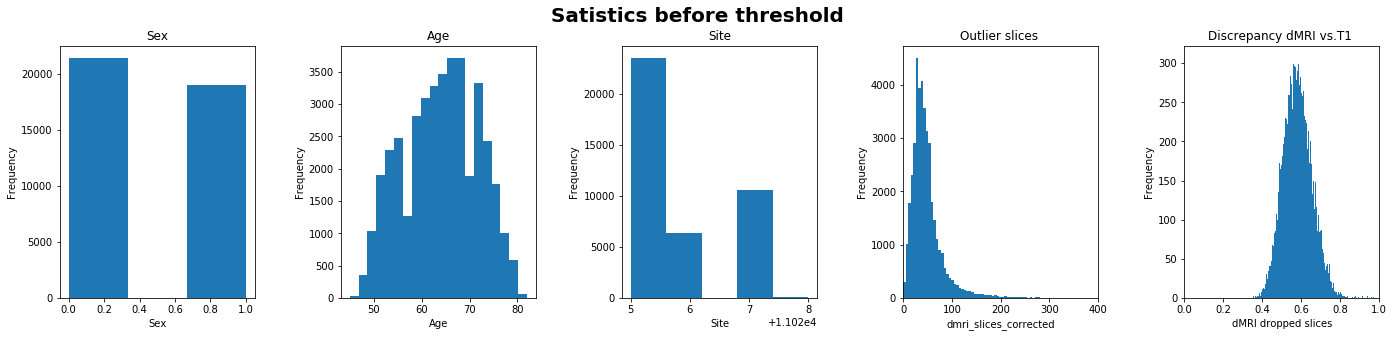

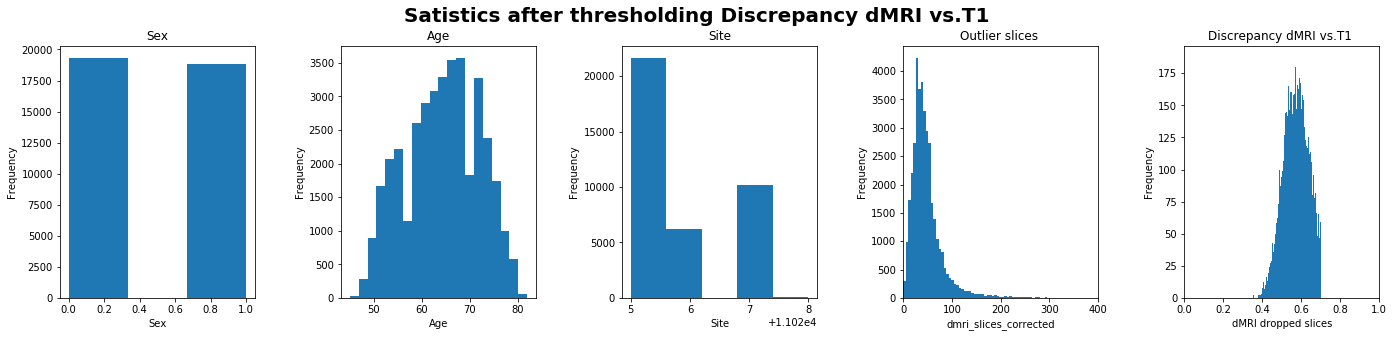

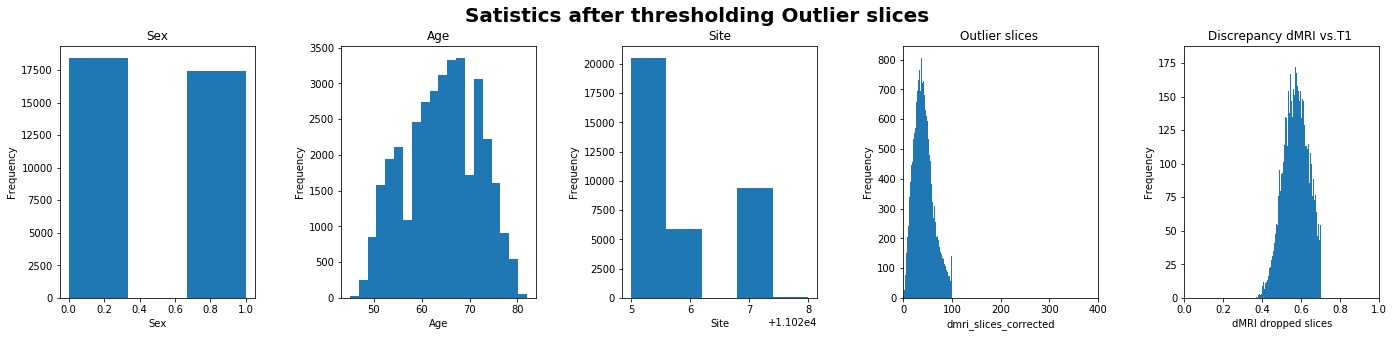

In [206]:
fig1 = plt.figure(figsize=(20, 5))

plt.subplot(1,5,1)
plt.hist(dmri_demo['sex'], bins=3)
plt.xlabel('Sex')
plt.ylabel('Frequency')
plt.title('Sex')

plt.subplot(1,5,2)
plt.hist(dmri_demo['age'], bins=20)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age')

plt.subplot(1,5,3)
plt.hist(dmri_demo['site'], bins=5)
plt.xlabel('Site')
plt.ylabel('Frequency')
plt.title('Site')

plt.subplot(1,5,4)
plt.hist(dmri_demo['dmri_slices_corrected'], bins=100)
plt.xlim([0,400])
plt.xlabel('dmri_slices_corrected')
plt.ylabel('Frequency')
plt.title('Outlier slices ')

plt.subplot(1,5,5)
plt.hist(dmri_demo['discrepancy_dmri_t1'], bins=500)
plt.xlim([0,1])
plt.xlabel('dMRI dropped slices')
plt.ylabel('Frequency')
plt.title('Discrepancy dMRI vs.T1 ')

fig1.suptitle('Satistics before threshold',fontweight ="bold", fontsize = 20.0)

fig1.tight_layout(pad = 3)
plt.show()

fig2 = plt.figure(figsize=(20, 5))

plt.subplot(1,5,1)
plt.hist(th1_dmri_demo['sex'], bins=3)
plt.xlabel('Sex')
plt.ylabel('Frequency')
plt.title('Sex')

plt.subplot(1,5,2)
plt.hist(th1_dmri_demo['age'], bins=20)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age')

plt.subplot(1,5,3)
plt.hist(th1_dmri_demo['site'], bins=5)
plt.xlabel('Site')
plt.ylabel('Frequency')
plt.title('Site')

plt.subplot(1,5,4)
plt.hist(th1_dmri_demo['dmri_slices_corrected'], bins=100)
plt.xlim([0,400])
plt.xlabel('dmri_slices_corrected')
plt.ylabel('Frequency')
plt.title('Outlier slices ')

plt.subplot(1,5,5)
plt.hist(th1_dmri_demo['discrepancy_dmri_t1'], bins=500)
plt.xlim([0,1])
plt.xlabel('dMRI dropped slices')
plt.ylabel('Frequency')
plt.title('Discrepancy dMRI vs.T1 ')

fig2.suptitle('Satistics after thresholding Discrepancy dMRI vs.T1',fontweight ="bold",fontsize = 20.0)

fig2.tight_layout(pad = 3)
plt.show()

fig3 = plt.figure(figsize=(20, 5))

plt.subplot(1,5,1)
plt.hist(th2_dmri_demo['sex'], bins=3)
plt.xlabel('Sex')
plt.ylabel('Frequency')
plt.title('Sex')

plt.subplot(1,5,2)
plt.hist(th2_dmri_demo['age'], bins=20)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age')

plt.subplot(1,5,3)
plt.hist(th2_dmri_demo['site'], bins=5)
plt.xlabel('Site')
plt.ylabel('Frequency')
plt.title('Site')

plt.subplot(1,5,4)
plt.hist(th2_dmri_demo['dmri_slices_corrected'], bins=100)
plt.xlim([0,400])
plt.xlabel('dmri_slices_corrected')
plt.ylabel('Frequency')
plt.title('Outlier slices ')

plt.subplot(1,5,5)
plt.hist(th2_dmri_demo['discrepancy_dmri_t1'], bins=500)
plt.xlim([0,1])
plt.xlabel('dMRI dropped slices')
plt.ylabel('Frequency')
plt.title('Discrepancy dMRI vs.T1 ')

fig3.suptitle('Satistics after thresholding Outlier slices',fontweight ="bold",fontsize = 20.0)

fig3.tight_layout(pad = 3)
plt.show()